# Dynamic Time Warping (DTW)

__author__ = "Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__license__ = "Open"
__version__ = "1.0.0"
__maintainer__ = "Rahul Kakodkar"
__email__ = "cacodcar@tamu.edu"
__status__ = "Production"




In the following example, we use deterministic data sets with different temporal resolutions as parameters for a mixed integer linear programming formulation (MILP) for integrated network design and scheduling of an energy system.

Agglomerative hierarchial clustering is used to cluster the time series data at different resolutions (hourly, daily) separately. The optimal set of representative days are different as expected. 

Cluster 1, has hourly data such as mileage target (demand factors), intermittent renewable resource availabilty (capacity factors)

Dynamic time warping (DTW) is then used to reconcile the data and create a surrogate temporal horizon which is a combination of both optimal set of clusters. The model is then solved over the surrogate temporal horizon and results are compared to the full scale formulation. 

The entire example is implemented on the energiapy python package, which uses the resource task network (RTN)approach. The figure below describes the problem in consideration.

energiapy's capabilities, as demonstrated in this example, include:

- Component based declaration of resources, materials, processes, locations, networks, transportation modes, and scenarios with all the requisite information conviniently embedded. 
- Multiscale models can be formulated to capture dynamics at disparate temporal resolutions. 
- Tools for data analysis and collection (through NSRDB API)
- Modules to reduce the scenarios using different clustering methodologies
- Plotting of data and results
- Post analysis of results, model summaries, computational time studies
- The ability to test out a large set of scenarios seamlessly 
- Problems are formulated bespoke and can be passed on to solver of choice 
- Variety of functions for mathematical analysis. (scaling, distance calculation, matrix generation)

capabilities not demonstrated in this example include:
- piecewise linear estimation of data
- graph reformulation
- post-reformulation of problem to assuage the impact of uncertainty by accessing the integer results

modules currently in development include:
- life cycle analysis 
- resiliency analysis
- carbon accounting



$\textbf{Import modules}$

In [1]:
import sys
sys.path.append('../../src')

In [2]:

import pandas 
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.components.result import Result 
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.model.solve import solve
from energiapy.aggregation.reduce_scenario import reduce_scenario, Clustermethod
from energiapy.aggregation.ahc import agg_hierarchial_elbow, IncludeAHC, Fit
from energiapy.aggregation.dtw import dynamic_warping, dynamic_warping_matrix, dynamic_warping_path, IncludeDTW
from energiapy.utils.data_utils import load_results
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import product
from pyearth import Earth
import pyomo.environ as pyo
import seaborn as sns


In [3]:
idx = [(i,j,k) for i,j,k in product(range(1), range(365), range(24))]

In [4]:
def mars_elbow(wcss:list, range_list:list):
    X = [numpy.array([i]) for i in range(len(wcss))]
    mars = Earth()
    mars.fit(X, wcss)
    y_hat = mars.predict(X)
    y_line = y_hat ## for plotting
    #determine the elbow point
    m = numpy.diff(y_line)/numpy.diff(range(len(wcss)))
    m = [numpy.round(i, 2) for i in m]
    m_un = list(set(m))
    elbow = max([m.index(i) + range_list[0] for i in sorted(m_un)])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    x = range_list

    ax.plot(x, y_line, label = 'MARS fit', color = 'steelblue', alpha = 0.6)

    ax.scatter(x, wcss, color = 'indianred')
    plt.axvline(x = elbow, alpha = 0.6, linestyle = 'dotted', label = f"elbow at {elbow}", color = 'slategrey', zorder = 3)    

    plt.title(f'Clustering using AHC for Houston for cost and demand')
    plt.xlabel('Cluster Size')
    plt.ylabel('WCSS')
    plt.grid(alpha=0.3)
    plt.legend()
    
    return elbow 


## Data Import

The following data is needed for the model

- solar and wind profiles : energiapy.fetch_nsrdb_data imports data from the NREL NSRDB database
- power demand : ERCOT for Houston; CAISO for San Diego
- Natural Gas prices: Henry Hub Price Index for both


**Get Weather data**

In [5]:
def load_data(loc:str, index:list):
    df = pandas.read_csv(f'../data/{loc}_solar19.csv')
    # df = df[['DNI', 'Wind Speed']]
    # df = df.rename(columns= {'DNI': 'dni', 'Wind Speed': 'wind_speed'})
    df['idx'] = index
    df = df.set_index('idx')
    return df

In [6]:
weather_ny = load_data('ny', idx)[['DNI', 'Wind Speed']]
weather_ny = weather_ny.rename(columns= {'DNI': 'dni', 'Wind Speed': 'wind_speed'})
weather_sd = load_data('sd', idx)[['dni', 'wind_speed']]
weather_ho = load_data('ho', idx)[['dni', 'wind_speed']]


**Demand data for San Diego (CAISO for SDGE region) and Houston (ERCOT for COAST region)**

In [8]:
demand_sd = pandas.read_excel('../data/HistoricalEMSHourlyLoad-2019.xlsx', index_col= 0)[['SDGE']]
demand_ho = pandas.read_excel('../data/Native_Load_2019.xlsx')[['COAST']]
demand_ny = pandas.DataFrame(pandas.read_csv('../data/NYC_load.csv')['Load']) #from Will and Doga
# Fix Index
demand_sd = demand_sd.set_index(weather_ho.index)
demand_ho = demand_ho.set_index(weather_ho.index)
demand_ny = demand_ny.set_index(weather_ho.index)



**Natural gas prices from Henry Hub Price Index**  

We use the special function energiapy.make_henry_price_df because of special requirements such as filling in empty data points (weekends, public holidays). Such function will be generalized in the next update of energipy

In [9]:
ng_price = make_henry_price_df(
    file_name='../data/Henry_Hub_Natural_Gas_Spot_Price_Daily.csv', year=2019, stretch=True)
# ng_price = ng_price.set_index(weather_sd.index[::24])
ng_price = ng_price.drop(columns= 'scales')
ng_price = remove_outliers(ng_price, sd_cuttoff = 3)
ng_price = ng_price.set_index(weather_ho.index)

## Define temporal scale


The variabilities of energy systems are best captured over a discretized spatio-temporal scale. In energiapy, the first declaration is the temporal scale. 

For e.g.: Here we declare three temporal scales at different levels from right to left. The interpretation of these scales is merely symentic. Scales can be declared as the problem demands.
- 0, annual, with 1 discretization
- 1, daily with 365 discretization
- 2, hourly with 24 discretization

In essence, we are creating a temporal scale of 8760 points.

In [11]:
scales = TemporalScale(discretization_list=[1, 365, 24])

## Declare resources

Resources can be consumed, produced, stored, discharged (or sold). 

In [12]:
Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max= 100, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', demand = True, label='Power generated', varying = [VaryingResource.DETERMINISTIC_DEMAND])

H2 = Resource(name='H2', basis='kg', label='Hydrogen', block='Resource')

H2_L = Resource(name='H2', basis='kg', label='Hydrogen', block='Resource', store_max = 10000)

CO2_AQoff = Resource(name='CO2_AQoff', basis='kg', label='Carbon dioxide - sequestered', store_max = 10000)

H2O = Resource(name='H2O', cons_max=10**10,
               price= 0.001, basis='kg', label='Water', block='Resource')

CH4 = Resource(name='CH4', cons_max=10**10, price=1, basis='kg', label='Natural gas', varying=  [VaryingResource.DETERMINISTIC_PRICE])

CO2 = Resource(name='CO2', basis='kg', label='Carbon dioxide', block='Resource')

CO2_Vent = Resource(name='CO2_Vent', sell=True, basis='kg', label='Carbon dioxide - Vented')

O2 = Resource(name='O2', sell=True, basis='kg', label='Oxygen')

CO2_DAC = Resource(name='CO2_DAC', basis='kg', label='Carbon dioxide - captured')


$\textbf{Declare processes}$

In [13]:
LiI = Process(name='LiI', storage= Power, capex = 1302182, fopex= 41432, vopex = 2000,  prod_max=100, label='Lithium-ion battery', basis = 'MW')

WF = Process(name='WF', conversion={Wind: -1, Power: 1},capex=990637, fopex=3354, vopex=4953, prod_max=100, label='Wind mill array', varying= [VaryingProcess.DETERMINISTIC_CAPACITY], basis = 'MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=567000, fopex=872046, vopex=90000, prod_max=100, varying = [VaryingProcess.DETERMINISTIC_CAPACITY], label = 'Solar PV', basis = 'MW')

SMRH = Process(name='SMRH', conversion={Power: -1.11*10**(-3), CH4: -3.76, H2O: -23.7, H2: 1, CO2_Vent: 1.03, CO2: 9.332}, capex =2520, fopex = 945, vopex = 0.0515,\
    prod_max= 10000, label='Steam methane reforming + CCUS')

SMR = Process(name='SMR', capex = 2400, fopex = 800, vopex = 0.03,  conversion={Power: -1.11*10**(-3), CH4: -3.76, H2O: -23.7, H2: 1, CO2_Vent: 9.4979}, prod_max=10000, label='Steam methane reforming')

H2FC = Process(name='H2FC', conversion = {H2:-50, Power: 1}, capex =  1.6*10**6, vopex = 3.5, fopex = 0, prod_max = 100, label = 'hydrogen fuel cell')

DAC = Process(name='DAC', capex = 0.02536, fopex = 0.634, vopex = 0, conversion={Power: -1.93*10**(-4), H2O: -4.048, CO2_DAC: 1}, prod_max=10000, label='Direct air capture')


H2_L_c = Process(name='H2_L_c', conversion={Power: -4.17*10**(-4), H2_L: 1, H2: -1}, capex =  1.6*10**6, vopex = 3.5, fopex = 0, prod_max= 10000, label='Hydrogen geological storage')

H2_L_d = Process(name='H2_L_d', conversion={H2_L: -1, H2: 1}, capex =  0.01, vopex = 0.001, fopex = 0, prod_max= 10000, label='Hydrogen geological storage discharge')

AQoff_SMR = Process(name='AQoff_SMR', conversion={Power: -0.00128, CO2_AQoff: 1, CO2: -1}, capex =  0.00552, vopex = 0.00414, fopex = 0, prod_max= 10000,  label='Offshore aquifer CO2 sequestration (SMR)')

Processes convert a resource into another through the utilization of resources. 
Essentially, the model is developed as an RTN

In [16]:
houston = Location(name='HO', processes= {LiI, PV, WF, SMRH, H2FC, DAC, AQoff_SMR}, capacity_factor = {PV: weather_ho[['dni']], WF: weather_ho[['wind_speed']]},\
    demand_factor= {Power: demand_ho}, price_factor = {CH4: ng_price}, scales=scales, label='Houston', demand_scale_level=2, capacity_scale_level= 2, price_scale_level= 2)

sandiego = Location(name='SD', processes= {LiI, PV, WF, SMRH, H2FC, DAC, AQoff_SMR}, capacity_factor = {PV: weather_sd[['dni']], WF: weather_sd[['wind_speed']]},\
    demand_factor= {Power: demand_sd}, price_factor = {CH4: ng_price}, scales=scales, label='SanDiego', demand_scale_level=2, capacity_scale_level= 2, price_scale_level= 2)

newyork = Location(name='NY', processes= {LiI, PV, WF, SMRH,  H2FC, DAC, AQoff_SMR}, capacity_factor = {PV: weather_ny[['dni']], WF: weather_ny[['wind_speed']]},\
    demand_factor= {Power: demand_ny}, price_factor = {CH4: ng_price}, scales=scales, label='NewYork', demand_scale_level=2, capacity_scale_level= 2, price_scale_level= 2)

Train_H2 = Transport(name= 'Train_H2', resources= {H2}, trans_max= 10000, trans_loss= 0.03, trans_cost= 1.667*10**(-3)\
    , label= 'Railway for hydrogen transportation')
Grid = Transport(name= 'Grid', resources= {Power}, trans_max= 300, trans_loss= 0.001, trans_cost= 0.5*10**(-3), label= 'Railroad transport')

distance_matrix = [
    [0, 2366, 2620],
    [2366, 0, 4440],
    [2620, 4440, 0]
                   ]

transport_matrix = [
    [[], [Grid, Train_H2], [Grid, Train_H2]],
    [[Grid, Train_H2], [], [Grid, Train_H2]],
    [[Grid, Train_H2], [Grid, Train_H2], []] 
                   ]

network = Network(name= 'Network', source_locations= [houston, sandiego, newyork], sink_locations= [houston, sandiego, newyork], distance_matrix= distance_matrix, transport_matrix= transport_matrix) 


scenario = Scenario(name= 'scenario_full', network= network, scales= scales,  expenditure_scale_level= 2, scheduling_scale_level= 2, \
    network_scale_level= 0, demand_scale_level= 2, label= 'full_case')


**Generate Indivual Scenarios and Determine WCSS**

In [17]:
range_list = list(range(30,150))

In [19]:
scenario_ho = Scenario(name= 'scenario_ho', network= houston, scales= scales,  expenditure_scale_level= 2, scheduling_scale_level= 2, \
    network_scale_level= 0, demand_scale_level= 2, label= 'max_demand_ho')

# wcss_ho = agg_hierarchial_elbow(scenario= scenario_ho, scale_level=1, include= [IncludeAHC.capacity, IncludeAHC.cost, IncludeAHC.demand], range_list = range_list)

# elbow_ho = mars_elbow(wcss_ho, range_list)
# elbow_ho = 117
elbow_ho = 30

scenario_ho_red, repdays_ho, info_ho =  reduce_scenario(scenario=scenario_ho, periods=elbow_ho, scale_level=1, method=Clustermethod.AHC, include = [IncludeAHC.CAPACITY, IncludeAHC.PRICE, IncludeAHC.DEMAND])


In [20]:

scenario_sd = Scenario(name= 'scenario_sd', network= sandiego, scales= scales,  expenditure_scale_level= 2, scheduling_scale_level= 2, \
    network_scale_level= 0, demand_scale_level= 2, label= 'max_demand_sd')

# wcss_sd = agg_hierarchial_elbow(scenario= scenario_sd, scale_level=1, include= [IncludeAHC.capacity, IncludeAHC.cost, IncludeAHC.demand], range_list = range_list)
#
# elbow_sd = mars_elbow(wcss_sd, range_list)
# elbow_sd = 117
elbow_sd = 40

scenario_sd_red, repdays_sd, info_sd =  reduce_scenario(scenario=scenario_sd, periods=elbow_sd, scale_level=1, method=Clustermethod.AHC, include = [IncludeAHC.CAPACITY, IncludeAHC.PRICE, IncludeAHC.DEMAND])



In [21]:

scenario_ny = Scenario(name= 'scenario_ny', network= newyork, scales= scales,  expenditure_scale_level= 2, scheduling_scale_level= 2, \
    network_scale_level= 0, demand_scale_level= 2, label= 'max_demand_ny')

# wcss_ny = agg_hierarchial_elbow(scenario= scenario_ny, scale_level=1, include= [IncludeAHC.capacity, IncludeAHC.cost, IncludeAHC.demand], range_list = range_list)

# elbow_ny = mars_elbow(wcss_ny, range_list)
# elbow_ny = 102
elbow_ny = 50


scenario_ny_red, repdays_ny, info_ny =  reduce_scenario(scenario=scenario_ny, periods=elbow_ny, scale_level=1, method=Clustermethod.AHC, include = [IncludeAHC.CAPACITY, IncludeAHC.PRICE, IncludeAHC.DEMAND])



**Time series for location-wise demand, capacity, and cost factors**

In [23]:
ho_pv = list(scenario_ho_red.capacity_factor['HO']['PV'].values())
ho_wf = list(scenario_ho_red.capacity_factor['HO']['WF'].values())
ho_dem = list(scenario_ho_red.demand_factor['HO']['Power'].values())
ho_ng = list(scenario_ho_red.price_factor['HO']['CH4'].values())

sd_pv = list(scenario_sd_red.capacity_factor['SD']['PV'].values())
sd_wf = list(scenario_sd_red.capacity_factor['SD']['WF'].values())
sd_dem = list(scenario_sd_red.demand_factor['SD']['Power'].values())
sd_ng = list(scenario_sd_red.price_factor['SD']['CH4'].values())

ny_pv = list(scenario_ny_red.capacity_factor['NY']['PV'].values())
ny_wf = list(scenario_ny_red.capacity_factor['NY']['WF'].values())
ny_dem = list(scenario_ny_red.demand_factor['NY']['Power'].values())
ny_ng = list(scenario_ny_red.price_factor['NY']['CH4'].values())


In [24]:
matrix = dynamic_warping_matrix(ny_ng, ho_ng)

In [25]:
path = dynamic_warping_path(matrix)

C:\Users\cacodcar\AppData\Local\Temp\ipykernel_668\3283229576.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


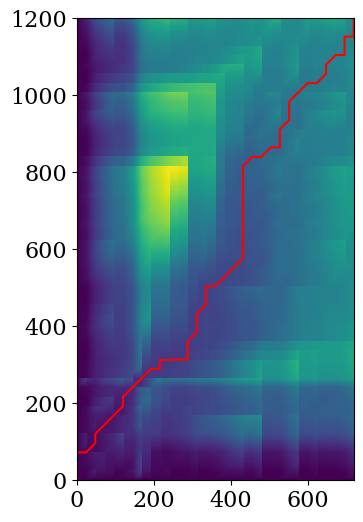

In [32]:
def dtwmap(matrix: numpy.ndarray, path: list, font_size: int = 16, usetex: bool = False):
    
    #get x and y co-ordinates
    x = [i[0] for i in path] 
    y = [i[1] for i in path]
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': font_size})
    rc('text', usetex=usetex)
    fig, ax = plt.subplots(figsize=(6, 6))

    
    ax.plot(y,x, color = 'red')
    plt.imshow(matrix, cmap='viridis', origin = 'lower', interpolation = 'nearest')    
    # plt.colorbar()
    fig.show()
    plt.rcdefaults()

dtwmap(matrix, path)